# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
#%autoreload

import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_extract
from pyspark.sql.types import FloatType, IntegerType

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

In [3]:
# load the data in spark
df_s = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df_s.createOrReplaceTempView("df_table")

In [5]:
df_s.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df_s.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Clean the column names and index

The values in the csv are structured like key:value. The key has to be extracted and defined as the column name. The values have to be converted to the correct data type.

In [7]:
df = df_s.toPandas()

In [8]:
df.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
97869,The Tokens,Logged In,Casey,F,84,Ramirez,116.40118,paid,"St. Louis, MO-IL",PUT,NextSong,1.534769e+12,1264,La Bamba,200,1540844213000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,109
170878,Eminem / Hailie Jade,Logged In,Sawyer,M,109,Larson,268.59057,paid,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,2009,My Dad's Gone Crazy,200,1542630077000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
23087,Sufjan Stevens,Logged In,Garrett,M,14,Jones,283.14077,free,"Troy, AL",PUT,NextSong,1.536955e+12,439,Come Thou Fount Of Every Blessing,200,1539021298000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",24
238154,Basement Jaxx,Logged In,Katiana,F,49,Daniels,204.69506,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1.537813e+12,242,Breakaway,200,1540772271000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",200023
170856,Robert Glasper,Logged In,Mishael,M,77,Ortega,440.45016,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1.540941e+12,2057,Silly Rabbit,200,1542629548000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",152


In [9]:
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         286500 non-nul

In [11]:
def get_unique_values(table_name, col_name):
    """
    Computes a list of unique values of the given
    table on the given column and returns a list.
    INPUT:
        table_name (str): name of the input table
        col_name (str): name of the column to search unique values
    OUTPUT:
        list (str): all unique values found
    """
    res = spark.sql("""
          SELECT DISTINCT {col_name}
          FROM {table_name}
          """.format(table_name=table_name,
                     col_name=col_name)).toPandas().values.flatten().tolist()
    return res

In [12]:
# Print unique values of interesting columns
unique_query_cols = ['page', 'auth', 'level', 'status', 'userAgent', 'gender']
for col in unique_query_cols:
    res = get_unique_values('df_table', col)
    print("Column '{}' has the {} following unique values:\n".format(col, len(res)), res)

Column 'page' has the 22 following unique values:
 ['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Submit Registration', 'Settings', 'Login', 'Register', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
Column 'auth' has the 4 following unique values:
 ['Logged Out', 'Cancelled', 'Guest', 'Logged In']
Column 'level' has the 2 following unique values:
 ['free', 'paid']
Column 'status' has the 3 following unique values:
 [307, 404, 200]
Column 'userAgent' has the 57 following unique values:
 ['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac O

#### Clean the userAgent column

This column contains a lot details that are most likely not relevant. However, the device type / OS type could be relevant, thus we extract it.

In [13]:
"""
Extract the user system from the userAgent column. Raw regexp that is applied:

Note: External braces need to be escaped with three backslashes for the sql query.
"""
userSystem = spark.sql('''
          SELECT *, regexp_extract(userAgent,
                                \"\\\(([a-zA-Z 0-9.]+)\", 1)
                                as userSystem
          FROM df_table
          ''')
userSystem.createOrReplaceTempView("df_table")

#### Remove empty user names

Login events have no assigned user name.

In [14]:
df_table = spark.sql("""
                      SELECT *
                      FROM df_table
                      WHERE userId <> ''
                      """)
df_table.createOrReplaceTempView("df_table")

## Delete unnecessary columns

The columns related to the name of the user, name of the listened song and the HTTP method (get/put) are deleted. The assumption is that this information does not affect the decision of a user to cancel its subscription.

In [15]:
df_s = spark.sql('''
                 SELECT userId, page, level, sessionId, ts, gender, itemInSession, userSystem, length, auth
                 FROM df_table
                 ''')
df_s.createOrReplaceTempView("df_table")

In [16]:
df = df_s.toPandas()

In [17]:
# Convirm that there are no missing values
df.isna().any()

userId           False
page             False
level            False
sessionId        False
ts               False
gender           False
itemInSession    False
userSystem       False
length            True
auth             False
dtype: bool

In [18]:
df.head()

,userId,page,level,sessionId,ts,gender,itemInSession,userSystem,length,auth
0,30,NextSong,paid,29,1538352117000,M,50,Windows NT 6.1,277.89016,Logged In
1,9,NextSong,free,8,1538352180000,M,79,Windows NT 6.1,236.09424,Logged In
2,30,NextSong,paid,29,1538352394000,M,51,Windows NT 6.1,282.82730,Logged In
3,9,NextSong,free,8,1538352416000,M,80,Windows NT 6.1,262.71302,Logged In
4,30,NextSong,paid,29,1538352676000,M,52,Windows NT 6.1,223.60771,Logged In


# Exploratory Data Analysis

In the following, a small subset of the data is loaded and basic manipulations are done within Spark. Various statistics are evaluated on the provided data in order to derive the right features.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [19]:
"""
Define a column `churn` that is 0 before a `Cancellation Confirmation` and 1 afterwards.

Calculation logic:
- binary encoding of the events
- cumulative sum over the binary encoding
"""
# binary encoding of the 'Cancellation Confirmation' events in column churn
df_s = spark.sql('''
                  SELECT *, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END as cancel_event
                  FROM df_table
                  ''')
df_s.createOrReplaceTempView('df_table')

In [20]:
# cumulative sum over the churn column to detect phases
df_s = spark.sql('''
          SELECT *,
          SUM(cancel_event) OVER (PARTITION BY userId) as churn
          FROM df_table
          ''')
df_s.createOrReplaceTempView("df_table")

### Get userId of loyal and churned users

Prepare two tables of `userId` separated by the fact whether this is a user that churned or a loyal user. This information is later needed to explore the daa based on the user group.

In [21]:
# Collect all userId of users that cancelled the subscription
cancelled_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) > 0
                          ''')
cancelled_userIds.createOrReplaceTempView("cancelled_userIds")

# print statistics
print("Overall {} users cancelled their subscription.".format(len(cancelled_userIds.collect())))

Overall 52 users cancelled their subscription.


In [22]:
# Collect all userId of users that cancelled the subscription
loyal_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) = 0
                          ''')
loyal_userIds.createOrReplaceTempView("loyal_userIds")

# print statistics
print("Overall {} users did not cancel their subscription.".format(len(loyal_userIds.collect())))

Overall 173 users did not cancel their subscription.


### Explore Data

After churn has been defined above, somee exploratory data analysis is performed in order to observe the behaviour for users who stayed vs users who churned. The evaluation is based on building aggregates on these two groups of users in order to observe difference in their usage logs.

#### Gender of the user

In the following it is evaluated whether the gender of a user shows correlation to the churn.

In [23]:
df_s.toPandas().head(5)

,userId,page,level,sessionId,ts,gender,itemInSession,userSystem,length,auth,cancel_event,churn
0,100010,NextSong,free,31,1539003534000,F,0,iPhone,202.97098,Logged In,0,0
1,100010,NextSong,free,31,1539003736000,F,1,iPhone,196.54485,Logged In,0,0
2,100010,NextSong,free,31,1539003932000,F,2,iPhone,263.13098,Logged In,0,0
3,100010,Thumbs Up,free,31,1539003933000,F,3,iPhone,NaN,Logged In,0,0
4,100010,NextSong,free,31,1539004195000,F,4,iPhone,316.23791,Logged In,0,0


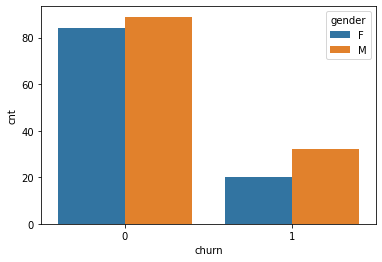

In [24]:
gender_df = spark.sql("""
          SELECT churn, gender, COUNT(gender) as cnt
          FROM (SELECT churn, userId, gender FROM df_table GROUP BY churn, userId, gender)
          GROUP BY churn, gender
          """).toPandas()
sns.barplot(data=gender_df, x='churn', y='cnt', hue='gender')

Even if it seems that the ratio of men is slightly higher among the users that churned, this could be caused by the small number of samples that actually churned.

#### Average length

The `length` event is filled out for `NextSong` and indicates the length of the played song. The listening behaviour could carry information about whether a user might `churn` or not.

In [25]:
# Extract the average length for both groups
lengths_pd = spark.sql('''
          SELECT userId, churn, avg(length)
          FROM df_table
          GROUP BY userId, churn
          ''').toPandas()

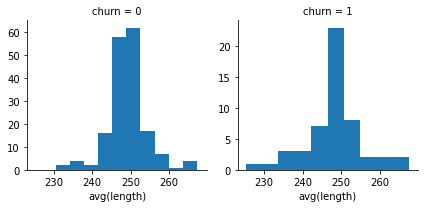

In [26]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(lengths_pd, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

Both distributions follow a different shape. Thus this feature will be included into the feature extraction process.

#### Items per session

The items per session can carry information about how intensively a user interacts with the portal and also about the session length. This could also contribute to explain the `churn`.

In [27]:
# For each user for each session, extract the average number of items to Pandas
items_per_sess_pd = spark.sql('''
          SELECT churn, userId, AVG(itemInSession) as avg
          FROM df_table
          GROUP BY churn, userId
          ''').toPandas()

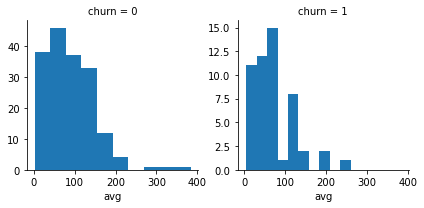

In [28]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(items_per_sess_pd, col="churn", sharey=False)
g.map(plt.hist, "avg");

The distribution of average events is more skewed for users that churned, indicating that this feature also carries information about a potential `churn`.

#### Average sessions per day

The average sessions per day is counted by dividing the overall session count of a given user by the number of days from the first event observed until the last event observed.

In [29]:
to_days = udf(lambda x: datetime.timedelta(milliseconds=x).days, IntegerType())
spark.udf.register("to_days", to_days)

<function __main__.<lambda>(x)>

In [30]:
# Add the feature for average sessions per day
avg_sess_per_day = """
                   SELECT churn, userId, COUNT(DISTINCT sessionId) / (to_days(MAX(ts) - MIN(ts))+1) as avg_sess_p_day
                   FROM df_table
                   GROUP BY churn, userId
                   """
avg_sess_p_day_pd = spark.sql(avg_sess_per_day).toPandas()

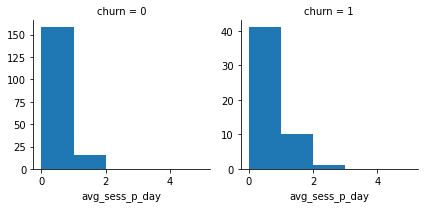

In [31]:
import numpy as np
bins = np.arange(0, 6, 1)

g = sns.FacetGrid(data=avg_sess_p_day_pd, col="churn", sharey=False)
g.map(plt.hist, "avg_sess_p_day", bins=bins)

The distribution for churned users tends to have a fatter tail. It can be assumed that this feature also contributes to the classification process.

#### Daytime of service usage

The daytime when the service is used might tell something about the potential of a user to churn. For example, users that frequently use the service in the evening might have a different churn rate than users that rather tend to use the service in the office or during lunch.

In [32]:
to_hour = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).hour), FloatType())
spark.udf.register("to_hour", to_hour)

<function __main__.<lambda>(x)>

In [33]:
# Add a column 'hour' to the data based on the timestamp 'ts'
hours_augmented = spark.sql('''
                   SELECT *, to_hour(ts) as hour
                   FROM df_table
                   ''')
hours_augmented.createOrReplaceTempView("df_table_hours")

In [34]:
def get_bucket_percentage(table, time_col, uid_table):
    """
    Returns a Pandas DataFrame which shows for a given user group 
    the percentage of actions during time bucket in column 'col'. This function
    is used to compute the data for loyal and churned users seperately.
    INPUT:
        table (str): name of a table view that contains the 'time_col' column and a 'userId' colummn
        time_col (str): name of the time column, i.e. 'weekday' or 'hour'
        userId_list (str): name of a table that contain a column userId only.
    OUTPUT:
        Pandas DataFrame which shows the total number of events per time bucket for the given user group
    """
    res = spark.sql("""
                    SELECT {time_col}, COUNT({time_col}) / (SELECT COUNT(*) FROM {table} WHERE userId IN (SELECT * FROM {uid_table})) as count 
                    FROM {table}  
                    WHERE userId IN (SELECT * FROM {uid_table})
                    GROUP BY {time_col}
                    ORDER BY count DESC 
                    """.format(uid_table=uid_table, time_col=time_col, table=table))
    res_pd = res.toPandas()
    return res_pd

In [35]:
loyal_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'loyal_userIds')
churn_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'cancelled_userIds')

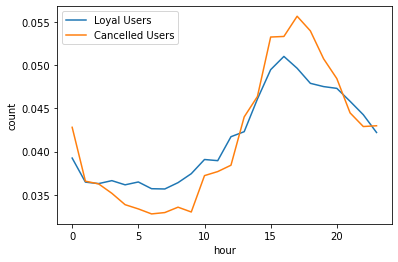

In [36]:
ax = sns.lineplot(x='hour', y='count', data=loyal_hours_pd, label='Loyal Users')
ax = sns.lineplot(x='hour', y='count', data=churn_hours_pd, label='Cancelled Users')
plt.show()

The data shows that `loyal` users are more active during the morning hours and `cancelled` users tend to have a relatively higher activity during the afternoon.

#### Weekday of service usage

The weekday might also play a role to distinguish users that churn from loyal users. For example, users that tend to use the service during workdays might have a different probability to churn than users that use the service during the weekend.

In [37]:
to_day = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).weekday()), FloatType())
spark.udf.register("to_day", to_day)

<function __main__.<lambda>(x)>

In [38]:
# Add a column 'weekday' to the data based on the timestamp 'ts'
weekdays_augmented = spark.sql('''
                   SELECT *, to_day(ts) as weekday
                   FROM df_table
                   ''')
weekdays_augmented.createOrReplaceTempView("df_table_weekdays")

In [39]:
loyal_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'loyal_userIds')
churn_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'cancelled_userIds')

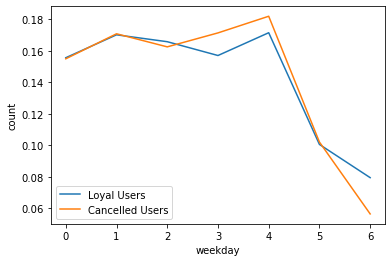

In [40]:
ax = sns.lineplot(x='weekday', y='count', data=loyal_weekdays_pd, label='Loyal Users')
ax = sns.lineplot(x='weekday', y='count', data=churn_weekdays_pd, label='Cancelled Users')
plt.show()

The percentage of usage follows a very similar line, however, cancelled users tend to listen more on Thursday and Friday, while loyal users tend to listen more on Sunday.

#### User system distribution

The type of user agent could play a role with regards to the churn rage, for example if the experience on a smartphone device is worse than on other devices. 

In [41]:
# Compute the most frequently used system for each user
pref_user_system_tbl = spark.sql("""
                            SELECT churn, userId, MAX(userSystem) as pref_user_system
                            FROM df_table
                            GROUP BY churn, userId
                            """)
pref_user_system_tbl.createOrReplaceTempView("pref_user_system_tbl")

In [42]:
# For each useer group, for each system, count the number of users
agg_user_system = spark.sql("""
                            SELECT churn, pref_user_system, 
                            COUNT(*) as cnt
                            FROM pref_user_system_tbl
                            GROUP BY churn, pref_user_system
                            """)
agg_user_system.createOrReplaceTempView("agg_user_system")

In [43]:
# Normalize the user count for each system by the overall number of users in that user group
user_system_perc_pd = spark.sql("""
          SELECT churn, pref_user_system, cnt / SUM(cnt) OVER (PARTITION BY churn) as percentage
          FROM agg_user_system
          """).toPandas()

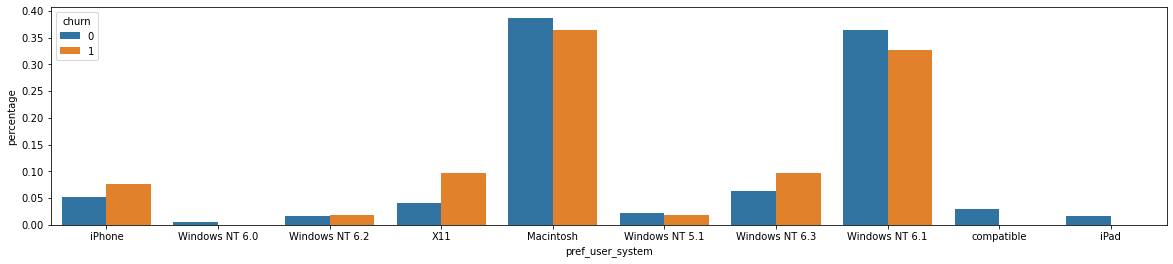

In [44]:
fig = plt.figure(figsize=(20,4))
ax = sns.barplot(x="pref_user_system", y="percentage", hue="churn", data=user_system_perc_pd)

Loyal users tend to use the iPad, iPad, MacOS, Windows NT 6.1 and compatible more often than users that cancelled. Probably the user experience is better than the desktop app, or people prefer to listen to music en route.

#### Length of the trace

The length of the trace helps to undertand the data. The idea is to compare the first and last timestamp of each user.

In [45]:
# Calculate the account lifetime in days
lifetimes = spark.sql('''
                      SELECT churn, userId, to_days(MAX(ts) - MIN(ts)) as lifetime
                      FROM df_table
                      GROUP BY churn, userId
                      ''')
lifetimes.createOrReplaceTempView("lifetime_table")

Plot the distribution of account ages (account lifetime):

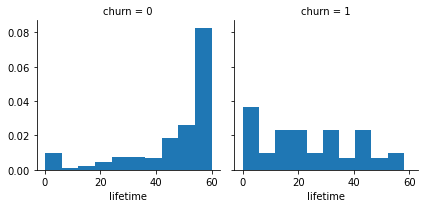

In [46]:
g = sns.FacetGrid(lifetimes.toPandas(), col='churn')
g.map(plt.hist, 'lifetime', density=True)

In [47]:
agg_lifetimes = spark.sql("""
          SELECT churn,
                 AVG(lifetime) as avg,
                 MIN(lifetime) as min,
                 MAX(lifetime) as max
          FROM lifetime_table
          GROUP BY churn
          """)
agg_lifetimes.createOrReplaceTempView("agg_lifetimes")

In [48]:
agg_lifetimes.toPandas()

,churn,avg,min,max
0,0,46.520231,0,60
1,1,23.134615,0,58


It seems that users cancel uniform distributed over the lifetime of the account. However, when account reaches a certain age of e.g. 60 days, it might carry information whether the user will cancel the subscription.

#### Average session duration

It can be assumed that the length of a session depends on the degree of satisfaction with the music service. This is evaluated by analyzing the quartiles of the session length of both user groups.

Sessions have a unique `sessionId`. The strategy is to group by `userId` and then for each `userId`, we group by `sessionId`. Within each session group, the timedelta between the first and the last timestamp describes the session duration. This duration is converted to seconds by a `udf`.

In [49]:
to_minutes = udf(lambda x: int(datetime.timedelta(milliseconds=x).seconds/60.), IntegerType())
spark.udf.register("to_minutes", to_minutes)

<function __main__.<lambda>(x)>

First, the duration of each session is computed and stored in a temp view:

In [50]:
session_lengths = spark.sql('''
                              SELECT churn, userId, sessionId, to_minutes(MAX(ts)-MIN(ts)) as session_duration
                              FROM df_table
                              GROUP BY churn, userId, sessionId
                              ORDER BY userId ASC, MIN(ts) ASC
                              ''')
session_lengths.createOrReplaceTempView("session_lengths")

Based on this DataFrame, the average session duration for each user group can be analyzed:

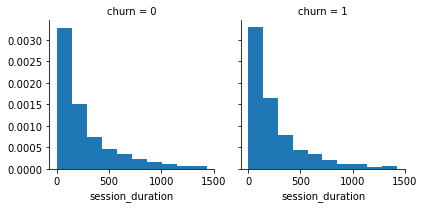

In [51]:
g = sns.FacetGrid(session_lengths.toPandas(), col='churn')
g.map(plt.hist, 'session_duration', density=True)

The distribution of session duration for churned users on the smaller test data has a stronger positive skew.

Based on this, the average, minimum and maximum session length for each user is calculated:

In [52]:
agg_session_lengths = spark.sql("""
          SELECT churn, userId,
                 AVG(session_duration) as avg,
                 MIN(session_duration) as min,
                 MAX(session_duration) as max
          FROM session_lengths
          GROUP BY churn, userId
          """)
agg_session_lengths.createOrReplaceTempView("agg_session_lengths")

The data is converted to Pandas and melted, in order to be able to create a seaborn plot:

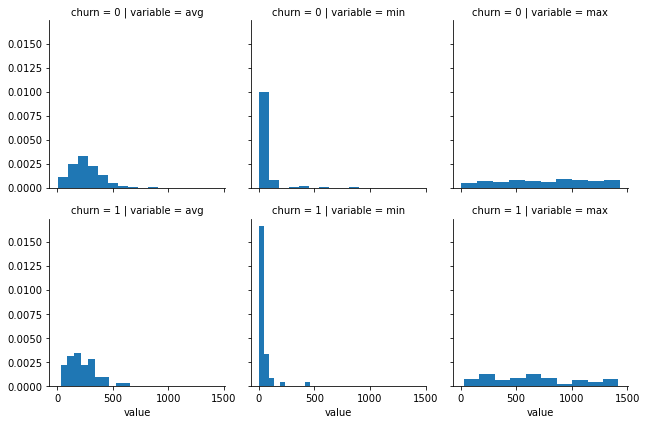

In [53]:
agg_session_lengths_pd = agg_session_lengths.toPandas()
agg_session_lengths_pd_melted = agg_session_lengths_pd.melt(id_vars=['churn', 'userId'])
g = sns.FacetGrid(agg_session_lengths_pd_melted, col='variable', row='churn')
g.map(plt.hist, 'value', density=True)

The upper row shows the average, minimum and maximum session duration for loyal users. The lower row shows these values for churned users. 

The distribution of listening times shows that for 50% of the user base, the group of cancelled users tends to longer session durations. However, the 9-tile shows that loyal users seem to prefer longer listening sessions.

The n-tile distribution of the session lengths for a given user could be a relevant feature to classify the user as `churn`.

#### Payment level

Users change the payment plan over time. The up- or downgrade could give an indication about a likelihood of cancellation. For example, the downgrade to a free usage could be a first indication that the user might delete his account.

In [54]:
up_down_grades = spark.sql('''
                  SELECT *, 
                      CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END as upgrade_event,
                      CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END as downgrade_event
                  FROM df_table
                  ''')
up_down_grades.createOrReplaceTempView('up_down_grades')

In [55]:
# cumulative sum over the churn column to detect phases
num_up_down_grades = spark.sql('''
          SELECT *,
              SUM(upgrade_event) OVER (PARTITION BY userId) as num_upgrades,
              SUM(downgrade_event) OVER (PARTITION BY userId) as num_downgrades
          FROM up_down_grades
          ''')
num_up_down_grades.createOrReplaceTempView("num_up_down_grades")

In [56]:
up_downgrades_pd = spark.sql("""
                      SELECT churn, userId, 
                              MAX(num_upgrades) as num_upgrades, 
                              MAX(num_downgrades) as num_downgrades
                      FROM num_up_down_grades
                      GROUP BY churn, userId
                      """).toPandas()

In [57]:
up_downgrades_pd.melt(id_vars=['churn', 'userId'])

,churn,userId,variable,value
0,0,100010,num_upgrades,0
1,0,200002,num_upgrades,1
2,1,125,num_upgrades,0
3,0,124,num_upgrades,0
4,1,51,num_upgrades,0
...,...,...,...,...
445,0,45,num_downgrades,0
446,0,57,num_downgrades,0
447,1,200021,num_downgrades,0
448,0,119,num_downgrades,0


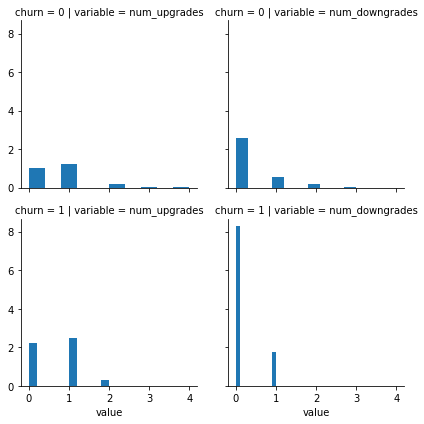

In [58]:
g = sns.FacetGrid(up_downgrades_pd.melt(id_vars=['churn', 'userId']), col='variable', row='churn')
g.map(plt.hist, 'value', density=True)

The left column compares the number of upgrades for both user groups. The up- and downgrade distribution looks similar for both groups

In [59]:
cncl_payment_dist_pd = spark.sql("""
                                  SELECT churn, level, COUNT(level)
                                  FROM df_table
                                  WHERE page = 'Cancellation Confirmation'
                                  GROUP BY churn, level
                                  """).toPandas()

In [60]:
cncl_payment_dist_pd

,churn,level,count(level)
0,1,paid,31
1,1,free,21


#### Average Click-count of pages per session

It can be assumed that loyal users tend to have a different click pattern than users that cancelled. For that, for each page, the average click count over all sessions of a given user group is calculated.

In [61]:
to_month = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).month), FloatType())
spark.udf.register("to_month", to_month)

<function __main__.<lambda>(x)>

In [62]:
# Aggregate the count for each page in each session
pages_per_session = spark.sql("""
                              SELECT churn, userId, sessionId, page, COUNT(page) as cnt, to_month(AVG(ts)) as month
                              FROM df_table
                              GROUP BY churn, userId, sessionId, page
                              """)
pages_per_session.createOrReplaceTempView("pages_per_session")

In [63]:
pages_per_session.toPandas()

,churn,userId,sessionId,page,cnt,month
0,0,100010,31,NextSong,31,10.0
1,0,100010,31,Thumbs Up,2,10.0
2,0,100010,31,Roll Advert,7,10.0
3,0,100010,78,NextSong,7,10.0
4,0,100010,78,Home,1,10.0
...,...,...,...,...,...,...
20208,1,100001,53,Roll Advert,2,10.0
20209,1,100001,53,Help,1,10.0
20210,1,100001,53,Logout,1,10.0
20211,1,100001,53,Cancel,1,10.0


In [64]:
# Average page counts per user per month
tmp = spark.sql("""
          SELECT churn, userId, page, month, AVG(cnt) as avg_cnt
          FROM pages_per_session
          GROUP BY churn, userId, page, month
          """)
tmp.createOrReplaceTempView("tmp")

In [65]:
# Average page counts per user over all months
tmp2 = spark.sql("""
          SELECT churn, userId, page, AVG(avg_cnt) as avg_mhly_cnt
          FROM tmp
          WHERE page <> "NextSong"
          GROUP BY churn, userId, page
          """)
tmp2.createOrReplaceTempView("tmp2")

In [66]:
tmp2.toPandas()

,churn,userId,page,avg_mhly_cnt
0,0,96,Save Settings,1.000000
1,0,79,Upgrade,2.000000
2,0,300015,Submit Downgrade,1.000000
3,0,115,Error,1.500000
4,1,28,Downgrade,3.750000
...,...,...,...,...
2879,0,300008,Settings,1.000000
2880,1,100005,Home,3.000000
2881,0,62,Save Settings,2.000000
2882,0,200025,Roll Advert,5.291667


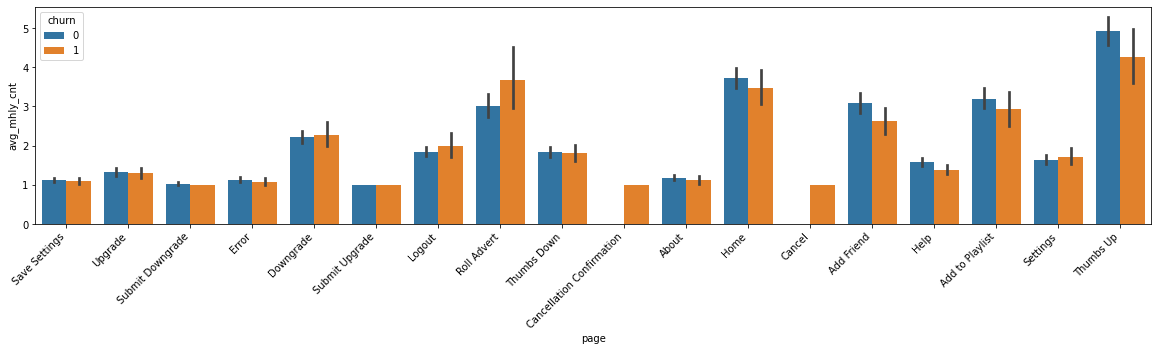

In [67]:
fig = plt.figure(figsize=(20,4))
ax = sns.barplot(x="page", y="avg_mhly_cnt", hue="churn", data=tmp2.toPandas())
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)
plt.show()

The average monthly click count for `NextSong` is not shown in this overview, as it is several times larger.

# Feature Engineering

In the following, the features are built out that seem promising to train the model on. The processing steps are stored in an external script. Basically, the following features are extracted

- Average sessions per day
- Average song length
- Average items per session
- Account age
- Average session duration
- Prefered user system as dummy variables
- The average click rate per session for each of the possible pages, except 'Cancellation Confirmation'

In [117]:
%load_ext autoreload
%autoreload 2

from src.ml_features import feature_extraction_pipe2
features_df2 = feature_extraction_pipe2(spark)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The script generated the following columns:

In [118]:
features_df2.columns

['userId',
 'churn',
 'avg_sess_p_day',
 'avg_length',
 'avg_items_p_sess',
 'acc_age',
 'avg_sess_len',
 'bin_gender',
 'pref_user_system',
 'pref_user_system_ind',
 'pref_user_system_ohe',
 'About',
 'Add_Friend',
 'Add_to_Playlist',
 'Cancel',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade']

The resulting DataFrame has the following shape:

In [ ]:
print(features_df2.count(), len(features_df2.columns))

#### Handling imbalanced classes

The `churn` is highly imbalanced over the provided samples, as the number of loyal users is more than 3 times higher than the number of cancelling users:

In [ ]:
spark.sql("SELECT churn, COUNT(*) as count FROM features_df GROUP BY churn").toPandas().plot.bar(x='churn')

In order to avoid a bias in the classifier, according measures need to be applied. Following choices are considered:
- Define a column `weightCol`, available after Spark 3.0.0
- Up- or Down-sample the classes

As at the time of writing no Docker image for Spark 3.0.0 was available, the approach of up- sampling is applied.

##### Up-sampling underrepresented classes

In order to balance the classses, the positive (`churn` = 1) examples are all used, and the set of negative examples is down-sampled according to the ratio of negative to positive samples.

In [ ]:
# Extract positive and negative samples
churn_neg_samples = features_df.filter(features_df.churn == 0)
churn_pos_samples = features_df.filter(features_df.churn == 1)

# Compute counts of both sets
churn_neg_cnt = churn_neg_samples.count()
churn_pos_cnt = churn_pos_samples.count()
print("churn_neg_cnt",churn_neg_cnt)
print("churn_pos_cnt",churn_pos_cnt)

In [ ]:
# Ratio of positive examples
pos_ratio = (float(churn_pos_cnt) / (churn_neg_cnt))

In [ ]:
# Perform the sub-sampling of negative examples
sampled = churn_neg_samples.sample(False, pos_ratio)

In [ ]:
# Union sub-sampled negative examples with positive examples
features_df_bal = sampled.union(churn_pos_samples)

In [ ]:
# Verify the new number of negative examples
features_df_bal.filter(features_df_bal.churn == 0).count()

##### Weights for samples (AFTER SPARK 3.0.0)

In [ ]:
# Add class weights to compensate unbalanced classes
weightCol =   """
              SELECT userId, CASE WHEN MAX(churn) = 1 
                                  THEN
                                    1 - (SELECT AVG(churn) FROM features_df)
                                  ELSE
                                    (SELECT AVG(churn) FROM features_df)
                                  END as weightCol
              FROM df_table
              GROUP BY userId
              """
features_df = add_feature(weightCol, 'weightCol')

# Modeling

Before the machine learning model can be selected and trained, the right performance measure for our Sparkify problem needs to be defined:
- Precision: `TP / (TP + FP)` - describes the percentage, when a reported cancelling user really was a cancelling user.
- Recall: `TP / (TP + FN)` - describes the percentage of cancelling users that were correctly detected.
- F1: Harmonic mean between Precision and Recall. Favors such models that have a balanced ratio of Precision and Recall.

In this project, the output of the classificator will be used to place discounts to users in order to avoid their cancellation. The right tradeoff between precision and recall decides between loosing revenue by granting unnecessary discounts or loosing revenue by not properly care for users that might cancel soon.

In case the classifier is tuned to a high recall and low precision, Sparkify would make sure that most of the potentially cancelling users get a discount and probably keep them as users. However, the Sparkify company would waste money due to the low precision, as loyal users are classified as cancelling users more often.

If the classifier is tuned to a low recall and high precision, the Sparkify streaming service could probably miss the timely discount for cancelling users, leading to higher cancellation rates. On the other side, the expenses for unnecessary discounts are reduced, as the detections of cancelling users are more precise.

The final decision largely depends on the pricing model of the company. What discount is needed to convince a customer to stay loyal? What is the monthly revenue generated by a loyal users? These numbers need to be considered when defining the correct threshold. As these details are not clear, in the following, the models are trained to get a balanced recall and precision ratio, thus the `F1` score is used.

First, the data set is split into two parts, a `train_test` set, that is used for 3-fold cross-validation, and a `validation` set. The following models are evaluated:

- Linear Support Vector Machine
- Naive Bayes
- Logistic Regression
- Random Forest

The single models are tuned based on a parameter grid-search and optimized against their `f1` score. The models are evaluated according to the `f1` score and their `accuracy`. The winning model is finally applied to the `validation` set.

For better readability, the code for each model is outsourced to the `src/ml_pipelines/` subfolder within this repository.

Upfront, the data sets for training and validation are created:

In [ ]:
# Split data for training/test and validation
train_test, validation = features_df_bal.randomSplit([0.9, 0.1], seed=42)

In [ ]:
train_test.printSchema()

In [ ]:
# Check for balanced classes
cncl_rate = train_test.filter((train_test.churn == 1)).count()/train_test.count()
print("The train_test data set contains {}% users that cancelled their subscription.".format(cncl_rate*100.))

In [ ]:
features_df_bal.columns

In [ ]:
# Define the features to be used in training

feature_cols = ['avg_sess_p_day',
                 'avg_length',
                 'avg_items_p_sess',
                 'acc_age',
                 'avg_sess_len'] # pref_user_system_ind created by the pipeline

*** TODO drop unnecessary cagorical features with Chi Squared? ***

## Linear Support Vector Machine (SVM)

The used machine learning pipeline is stored in the file `src/ml_pipe_factory.py`. If basically does:

- Feature scaling: TODO MinMaxScaler/Normalizer is good if there are no outliers. Standardizer is good if there are outliers. TODO: Which to use on which feature?

### SVM Training

In [ ]:
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# VectorAssembler
vecAssembler = VectorAssembler(inputCols=["avg_sess_p_day",
                                          "avg_length",
                                          "avg_items_p_sess",
                                          "acc_age",
                                          "avg_sess_len"],
                               outputCol="features")

# Normalizer / Scaler
maScaler = MaxAbsScaler(inputCol="features",
                        outputCol="features_scaled")

# Create the model
svm = LinearSVC(featuresCol='features_scaled',
                labelCol='churn', 
                predictionCol='prediction')

# Fit the model

In [ ]:
# Define a pipeline
pipe = Pipeline(stages=[vecAssembler,
                        maScaler,
                        svm])

grid = ParamGridBuilder().addGrid(svm.regParam, [0]).build()

# Use cross-validation
cv = CrossValidator(estimator=pipe,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',
                                                                #rawPredictionCol='Prediction',
                                                                metricName='f1'),
                    estimatorParamMaps=grid,
                    numFolds=3,
                    parallelism=4)

In [ ]:
cvModel = cv.fit(train_test)

In [ ]:
results2 = cvModel.transform(train_test)

In [ ]:
cv.getEvaluator().evaluate(results2, {cv.getEvaluator().metricName: "f1"})

In [ ]:
# Import various candidate models
%load_ext autoreload
%autoreload 2

from src.ml_pipe_factory import build_svm_pipeline

In [ ]:
# Split data for training/test and validation
train_test, validation = features_df_bal.randomSplit([0.9, 0.1], seed=42)

# Build the SVM pipeline
svm_pipeline = build_svm_pipeline(inputCols = feature_cols)

In [ ]:
# Execute the training
svm_model = svm_pipeline.fit(train_test)

In [ ]:
# Save the model
import pathlib
model_path = str(pathlib.Path().absolute() / "model" / "svm2")
svm_model.bestModel.write().overwrite().save(model_path)

### SVM Evaluation

The SVM model is evaluated in the following cells.

In [ ]:
%load_ext autoreload
%autoreload 2

from src.evaluator import evaluate_model
from pyspark.ml import PipelineModel
import pathlib

# Load the model
model_path = str(pathlib.Path().absolute() / "model" / "svm2")
svmModel = PipelineModel.load(model_path)

In [ ]:
# Create predictions
svm_results = svmModel.transform(train_test)

In [ ]:
svm_results.filter(svm_results.prediction < 1.0).count()

In [ ]:
# Evaluate the predictions
metrics_svm = evaluate_model(svm_results, "SVM")

In [ ]:
metrics_svm

## Naive Bayes Classifier (NB)

### NB Training

In [ ]:
# Import various candidate models
from src.ml_pipe_factory import build_naivebayes_pipeline

# Build the NB pipeline
nb_pipeline = build_naivebayes_pipeline(inputCols = feature_cols)

In [ ]:
# Execute the training
nb = nb_pipeline.fit(train_test)

In [ ]:
# Save the model
import pathlib
nb_path = str(pathlib.Path().absolute() / "model" / "naivebayes")
nb.bestModel.write().overwrite().save(nb_path)

### NB Evaluation

In [ ]:
# Load the model
nbModel = PipelineModel.load(nb_path)

# Create predictions
nb_results = nbModel.transform(train_test)

# Evaluate the predictions
metrics_nb = evaluate_model(nb_results, "NaiveBayes")
metrics_nb

## Logistic Regression (LR)

### LR Training

In [ ]:
# Import various candidate models
from src.ml_pipe_factory import build_logreg_pipeline

# Build the LR pipeline
lr_pipeline = build_logreg_pipeline(inputCols = feature_cols)

In [ ]:
# Execute the training
lr = lr_pipeline.fit(train_test)

In [ ]:
# Save the model
import pathlib
lr_path = str(pathlib.Path().absolute() / "model" / "logreg")
lr.bestModel.write().overwrite().save(lr_path)

### LR Evaluation

In [ ]:
# Load the model
lrModel = PipelineModel.load(lr_path)

# Create predictions
lr_results = lrModel.transform(train_test)

# Evaluate the predictions
metrics_lr = evaluate_model(lr_results, "Logistic Regression")
metrics_lr

## Random Forest (RF)

### RF Training

In [ ]:
# Import various candidate models
from src.ml_pipe_factory import build_randomforest_pipeline

# Build the RF pipeline
rf_pipeline = build_randomforest_pipeline(inputCols = feature_cols)

In [ ]:
# Execute the training
rf = rf_pipeline.fit(train_test)

In [ ]:
# Save the model
import pathlib
rf_path = str(pathlib.Path().absolute() / "model" / "rndmforest")
rf.bestModel.write().overwrite().save(rf_path)

### RF Evaluation

In [ ]:
rfModel[2].featureImportances()

In [ ]:
# Load the model
rfModel = PipelineModel.load(rf_path)

# Create predictions
rf_results = rfModel.transform(train_test)

# Evaluate the predictions
metrics_rf = evaluate_model(rf_results, "Random Forest")
metrics_rf

## Evaluation Summary

In [ ]:
metrics_df = pd.DataFrame.from_records([metrics_rf,
                        metrics_lr,
                        metrics_nb])

In [ ]:
metrics_df_melted = metrics_df.melt(id_vars="model")

In [ ]:
metrics_df_melted.rename(columns={'model':"Model",
                                  'variable':"Metric",
                                  'value':"Score"},
                        inplace=True)

In [ ]:
fig = plt.figure(figsize=(8,3))
ax = sns.barplot(x="Metric", y="Score", hue="Model", data=metrics_df_melted)
plt.grid("on")

Final descriptive text goes here...

# Summary
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.